## Introducción

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

## Inicialización

In [98]:
#Cargar las librerías 
# Librerías estándar de Python
import math as mt

# Librerías de terceros
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as st
from fancyimpute import IterativeImputer
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    r2_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBClassifier
from catboost import CatBoostRegressor


## Cargar datos

In [2]:
internet = pd.read_csv("final_provider/final_provider/internet.csv")
contract = pd.read_csv("final_provider/final_provider/contract.csv")
personal = pd.read_csv("final_provider/final_provider/personal.csv")
phone = pd.read_csv("final_provider/final_provider/phone.csv")

## Preprocesamiento y EDA

#### Internet 

In [3]:
#Revisar la cantidad de datos, su formato y si hay columnas con valores ausentes
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [4]:
#Imprimir una muestra de 10 filas para ver la información provista
internet.sample(10, random_state=123)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2730,4682-BLBUC,DSL,No,Yes,Yes,Yes,Yes,No
4071,7668-XCFYV,Fiber optic,No,No,No,No,Yes,Yes
137,6727-IOTLZ,DSL,No,Yes,Yes,Yes,Yes,Yes
724,2719-BDAQO,Fiber optic,Yes,No,No,No,Yes,Yes
3821,1394-SUIUH,Fiber optic,Yes,Yes,No,Yes,No,No
3724,0018-NYROU,Fiber optic,No,No,No,No,No,No
1155,5899-OUVKV,Fiber optic,No,Yes,No,No,Yes,Yes
1463,7054-LGEQW,DSL,No,No,No,No,No,No
95,5256-SKJGO,DSL,No,Yes,No,Yes,Yes,Yes
222,3179-GBRWV,DSL,Yes,Yes,No,No,No,Yes


In [5]:
#Crear una función para contabilizar los tipos de valores incluyendo los ausentes
def valores_ausentes(column):
    return column.value_counts(dropna=False).sort_index()

In [6]:
#Revisar valores ausentes en la columna 'InternetService'
valores_ausentes(internet['InternetService'])

InternetService
DSL            2421
Fiber optic    3096
Name: count, dtype: int64

In [7]:
#Revisar valores ausentes en la columna 'OnlineSecurity'
valores_ausentes(internet['OnlineSecurity'])

OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64

In [8]:
#Revisar valores ausentes en la columna 'OnlineBackup'
valores_ausentes(internet['OnlineBackup'])

OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64

In [9]:
#Revisar valores ausentes en la columna 'DeviceProtection'
valores_ausentes(internet['DeviceProtection'])

DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64

In [10]:
#Revisar valores ausentes en la columna 'TechSupport'
valores_ausentes(internet['TechSupport'])

TechSupport
No     3473
Yes    2044
Name: count, dtype: int64

In [11]:
#Revisar valores ausentes en la columna 'StreamingTV'
valores_ausentes(internet['StreamingTV'])

StreamingTV
No     2810
Yes    2707
Name: count, dtype: int64

In [12]:
#Revisar valores ausentes en la columna 'StreamingMovies'
valores_ausentes(internet['StreamingMovies'])

StreamingMovies
No     2785
Yes    2732
Name: count, dtype: int64

In [13]:
#Revisar los valores duplicados
internet.duplicated().sum()

0

In [14]:
#Separar las columnas categoricas
services_columns= ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

In [15]:
#Convertir los datos de las columnas en codigo binario y sumar los servicios para crear una sola columna
internet[services_columns] = internet[services_columns].replace({'Yes':1, 'No':0})
internet['NumOfServices'] = internet[services_columns].sum(axis=1)

In [16]:
#Imprimir una muestra del dataframe modificado con la columna agregada de los servicios agregados
internet.sample(10, random_state=123)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,NumOfServices
2730,4682-BLBUC,DSL,0,1,1,1,1,0,4
4071,7668-XCFYV,Fiber optic,0,0,0,0,1,1,2
137,6727-IOTLZ,DSL,0,1,1,1,1,1,5
724,2719-BDAQO,Fiber optic,1,0,0,0,1,1,3
3821,1394-SUIUH,Fiber optic,1,1,0,1,0,0,3
3724,0018-NYROU,Fiber optic,0,0,0,0,0,0,0
1155,5899-OUVKV,Fiber optic,0,1,0,0,1,1,3
1463,7054-LGEQW,DSL,0,0,0,0,0,0,0
95,5256-SKJGO,DSL,0,1,0,1,1,1,4
222,3179-GBRWV,DSL,1,1,0,0,0,1,3


In [17]:
#Crear un nuevo dataframe solo con las columnas relevantes
internet_cut = internet[['customerID', 'InternetService', 'NumOfServices']]

In [18]:
#imprimir una muestra del dataframe creado solo con los servicios agregados
internet_cut.sample(10, random_state=123)

,customerID,InternetService,NumOfServices
2730,4682-BLBUC,DSL,4
4071,7668-XCFYV,Fiber optic,2
137,6727-IOTLZ,DSL,5
724,2719-BDAQO,Fiber optic,3
3821,1394-SUIUH,Fiber optic,3
3724,0018-NYROU,Fiber optic,0
1155,5899-OUVKV,Fiber optic,3
1463,7054-LGEQW,DSL,0
95,5256-SKJGO,DSL,4
222,3179-GBRWV,DSL,3


#### Contract

In [19]:
#Revisar la cantidad de datos, su formato y si hay columnas con valores ausentes
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [20]:
#Imprimir una muestra de 10 filas del dataframe contract para ver la información que contiene
contract.sample(10, random_state=123)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
941,0811-GSDTP,2019-01-01,No,Month-to-month,No,Electronic check,30.15,382.2
1404,1970-KKFWL,2017-03-01,No,Two year,No,Bank transfer (automatic),23.30,797.1
5515,2892-GESUL,2018-08-01,No,Two year,No,Mailed check,19.35,309.25
3684,2842-BCQGE,2016-07-01,No,Month-to-month,Yes,Credit card (automatic),75.35,3161.4
7017,4807-IZYOZ,2015-11-01,No,Two year,No,Bank transfer (automatic),20.65,1020.75
3643,9451-WLYRI,2015-09-01,No,One year,No,Credit card (automatic),19.05,990.45
3846,1767-TGTKO,2019-06-01,No,Month-to-month,Yes,Electronic check,45.45,411.75
6185,8033-VCZGH,2015-12-01,No,One year,Yes,Electronic check,103.95,5231.3
613,6689-VRRTK,2016-06-01,No,One year,Yes,Credit card (automatic),109.80,4860.35
2680,6997-UVGOX,2014-03-01,No,Two year,No,Bank transfer (automatic),85.45,6029.9


In [21]:
#Revisar los valores ausentes del dataframe contract
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [22]:
#Revisar los valores ausentes de la columna 'BeginDate'
valores_ausentes(contract['BeginDate'])

BeginDate
2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
             ... 
2019-10-01    237
2019-11-01    237
2019-12-01    220
2020-01-01    233
2020-02-01     11
Name: count, Length: 77, dtype: int64

In [23]:
#Revisar los valores ausentes de la columna 'EndDate'
valores_ausentes(contract['EndDate'])

EndDate
2019-10-01 00:00:00     458
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
No                     5174
Name: count, dtype: int64

In [24]:
#Revisar los valores ausentes de la columna 'Type'
valores_ausentes(contract['Type'])

Type
Month-to-month    3875
One year          1473
Two year          1695
Name: count, dtype: int64

In [25]:
#Revisar los valores ausentes de la columna 'PaperlessBilling'
valores_ausentes(contract['PaperlessBilling'])

PaperlessBilling
No     2872
Yes    4171
Name: count, dtype: int64

In [26]:
#Revisar los valores ausentes de la columna 'PaymentMethod'
valores_ausentes(contract['PaymentMethod'])

PaymentMethod
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Electronic check             2365
Mailed check                 1612
Name: count, dtype: int64

In [27]:
#Revisar los valores ausentes de la columna 'MonthlyCharges'
valores_ausentes(contract['MonthlyCharges'])

MonthlyCharges
18.25     1
18.40     1
18.55     1
18.70     2
18.75     1
         ..
118.20    1
118.35    1
118.60    2
118.65    1
118.75    1
Name: count, Length: 1585, dtype: int64

In [28]:
#Describir los valores de la columna 'MonthlyCharges'
contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [29]:
#Revisar los valores ausentes de la columna 'TotalCharges'
valores_ausentes(contract['TotalCharges'])

TotalCharges
          11
100.2      1
100.25     1
100.35     1
100.4      1
          ..
997.75     1
998.1      1
999.45     1
999.8      1
999.9      1
Name: count, Length: 6531, dtype: int64

In [30]:
#Reemplazar los valores ausentes con NaN para poder convertir los valores en tipo numerico o float
contract['TotalCharges'] = contract['TotalCharges'].replace([' ', ''], np.nan)
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
print(contract['TotalCharges'].value_counts(dropna=False).sort_index())

TotalCharges
18.80       1
18.85       2
18.90       1
19.00       1
19.05       1
           ..
8594.40     1
8670.10     1
8672.45     1
8684.80     1
NaN        11
Name: count, Length: 6531, dtype: int64


In [31]:
#Verificar que se haya modificado el tipo de valor (a float)
contract['TotalCharges'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: TotalCharges
Non-Null Count  Dtype  
--------------  -----  
7032 non-null   float64
dtypes: float64(1)
memory usage: 55.2 KB


In [32]:
#Verificar los valores duplicados
contract.duplicated().sum()

0

In [33]:
#Obtener una muestra del dataframe modificado
contract.sample(10, random_state=12)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6235,5180-UCIIQ,2018-03-01,2020-01-01 00:00:00,Month-to-month,No,Mailed check,40.05,880.20
3980,8868-WOZGU,2017-08-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,105.70,2979.50
6548,5012-YSPJJ,2017-07-01,No,Month-to-month,No,Mailed check,54.35,1647.00
3954,7225-CBZPL,2018-09-01,No,Month-to-month,Yes,Electronic check,94.80,1563.90
5328,0334-ZFJSR,2015-07-01,No,One year,Yes,Credit card (automatic),66.05,3462.10
2462,2585-KTFRE,2020-01-01,No,Month-to-month,Yes,Bank transfer (automatic),70.45,70.45
2872,8148-NLEGT,2016-08-01,No,Two year,No,Electronic check,22.95,1014.25
860,4795-UXVCJ,2017-12-01,No,One year,No,Credit card (automatic),19.80,457.30
968,3429-IFLEM,2014-03-01,No,Two year,No,Credit card (automatic),77.35,5550.10
6368,2720-WGKHP,2019-08-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,94.00,181.70


In [34]:
#Convertit las columas con observaciones de tiempo a tipo datetime despues de convertir los valores object a NaN
contract['EndDate'] = contract['EndDate'].replace('No', pd.NaT)
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d',  errors='ignore')


In [35]:
#Agregar una nueva columna 'Churn' como nuestra columna objetivo y convertirlo en codigo binario
contract['Churn'] = contract['EndDate'].apply(lambda x:1 if pd.notna(x) else 0)

In [36]:
#Imprimir una muestra del dataframe modificado
contract.sample(10, random_state=12)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6235,5180-UCIIQ,2018-03-01,2020-01-01 00:00:00,Month-to-month,No,Mailed check,40.05,880.20,1
3980,8868-WOZGU,2017-08-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,105.70,2979.50,1
6548,5012-YSPJJ,2017-07-01,NaT,Month-to-month,No,Mailed check,54.35,1647.00,0
3954,7225-CBZPL,2018-09-01,NaT,Month-to-month,Yes,Electronic check,94.80,1563.90,0
5328,0334-ZFJSR,2015-07-01,NaT,One year,Yes,Credit card (automatic),66.05,3462.10,0
2462,2585-KTFRE,2020-01-01,NaT,Month-to-month,Yes,Bank transfer (automatic),70.45,70.45,0
2872,8148-NLEGT,2016-08-01,NaT,Two year,No,Electronic check,22.95,1014.25,0
860,4795-UXVCJ,2017-12-01,NaT,One year,No,Credit card (automatic),19.80,457.30,0
968,3429-IFLEM,2014-03-01,NaT,Two year,No,Credit card (automatic),77.35,5550.10,0
6368,2720-WGKHP,2019-08-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,94.00,181.70,1


In [37]:
#Verificar que ya no hayan valores ausentes
valores_ausentes(contract['Churn'])

Churn
0    5174
1    1869
Name: count, dtype: int64

In [38]:
#Convertit las columas con observaciones de tiempo a tipo datetime 
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d', errors='ignore')

In [39]:
#Verificar que la columan modificada tenga el tipo correcto de datos
contract['BeginDate'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: BeginDate
Non-Null Count  Dtype         
--------------  -----         
7043 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 55.2 KB


### Personal

In [40]:
#Revisar la cantidad de datos, su formato y si hay columnas con valores ausentes del dataframe 'personal'
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [41]:
#Imprimir una muestra del dataframe 'personal' para ver la información provista
personal.sample(10, random_state=123)

,customerID,gender,SeniorCitizen,Partner,Dependents
941,0811-GSDTP,Female,0,No,Yes
1404,1970-KKFWL,Female,0,No,No
5515,2892-GESUL,Female,0,Yes,Yes
3684,2842-BCQGE,Male,0,No,No
7017,4807-IZYOZ,Female,0,No,No
3643,9451-WLYRI,Female,0,Yes,No
3846,1767-TGTKO,Female,0,Yes,Yes
6185,8033-VCZGH,Male,0,Yes,No
613,6689-VRRTK,Female,1,No,No
2680,6997-UVGOX,Male,0,Yes,Yes


In [42]:
#Revisar valores ausentes
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [43]:
#Revisar valores ausentes en la columna 'gender'
valores_ausentes(personal['gender'])

gender
Female    3488
Male      3555
Name: count, dtype: int64

In [44]:
#Revisar valores ausentes en la columna 'SeniorCitizen'
valores_ausentes(personal['SeniorCitizen'])

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

In [45]:
#Revisar valores ausentes en la columna 'Partner'
valores_ausentes(personal['Partner'])

Partner
No     3641
Yes    3402
Name: count, dtype: int64

In [46]:
#Revisar valores ausentes en la columna 'Dependents'
valores_ausentes(personal['Dependents'])

Dependents
No     4933
Yes    2110
Name: count, dtype: int64

In [47]:
#Revisar valores duplicados
personal.duplicated().sum()

0

### Phone

In [48]:
#Revisar la cantidad de datos, su formato y si hay columnas con valores ausentes del dataframe 'phone'
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [49]:
#Imprimir una muestra del dataframe 'phone' para ver la información provista
phone.sample(10, random_state=123)

,customerID,MultipleLines
1868,8543-MSDMF,No
1896,7228-PAQPD,No
4150,3709-OIJEA,No
5335,2296-DKZFP,No
4728,2983-ZANRP,No
6154,2030-BTZRO,No
1917,6227-FBDXH,Yes
1642,0839-QNXME,No
3629,6986-IXNDM,No
1854,3753-TSEMP,No


In [50]:
#Verificar que el dataframe no contenga valores ausentes 
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [51]:
#Revisar valores ausentes en la columna 'MultipleLines'
valores_ausentes(phone['MultipleLines'])

MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64

In [52]:
#Verificar que no haya valores duplicados
phone.duplicated().sum()

0

#### Unir los dataframes 

In [53]:
#Unir los diferentes dataframes de acuerdo con el customer_id y demanera que no se mantenga la longitud máxima del df mas grande
data_merged = contract.merge(internet_cut, on ='customerID', how='outer')
data_merged = data_merged.merge(personal, on='customerID', how='outer')
data_merged = data_merged.merge(phone, on='customerID', how='outer')

In [54]:
#Obtenermos una muestra de los dataframes agregados 
data_merged.sample(10, random_state=123)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,NumOfServices,gender,SeniorCitizen,Partner,Dependents,MultipleLines
941,0811-GSDTP,2019-01-01,NaT,Month-to-month,No,Electronic check,30.15,382.20,0,DSL,1.0,Female,0,No,Yes,NaN
1404,1970-KKFWL,2017-03-01,NaT,Two year,No,Bank transfer (automatic),23.30,797.10,0,NaN,NaN,Female,0,No,No,Yes
5515,2892-GESUL,2018-08-01,NaT,Two year,No,Mailed check,19.35,309.25,0,NaN,NaN,Female,0,Yes,Yes,No
3684,2842-BCQGE,2016-07-01,NaT,Month-to-month,Yes,Credit card (automatic),75.35,3161.40,0,Fiber optic,0.0,Male,0,No,No,Yes
7017,4807-IZYOZ,2015-11-01,NaT,Two year,No,Bank transfer (automatic),20.65,1020.75,0,NaN,NaN,Female,0,No,No,No
3643,9451-WLYRI,2015-09-01,NaT,One year,No,Credit card (automatic),19.05,990.45,0,NaN,NaN,Female,0,Yes,No,No
3846,1767-TGTKO,2019-06-01,NaT,Month-to-month,Yes,Electronic check,45.45,411.75,0,DSL,0.0,Female,0,Yes,Yes,No
6185,8033-VCZGH,2015-12-01,NaT,One year,Yes,Electronic check,103.95,5231.30,0,Fiber optic,4.0,Male,0,Yes,No,Yes
613,6689-VRRTK,2016-06-01,NaT,One year,Yes,Credit card (automatic),109.80,4860.35,0,Fiber optic,5.0,Female,1,No,No,Yes
2680,6997-UVGOX,2014-03-01,NaT,Two year,No,Bank transfer (automatic),85.45,6029.90,0,DSL,6.0,Male,0,Yes,Yes,No


In [55]:
#Revisamos si se generaron valores ausentes al momento de unir los dfs en la columna 'TotalCharges'
valores_ausentes(data_merged['TotalCharges'])

TotalCharges
18.80       1
18.85       2
18.90       1
19.00       1
19.05       1
           ..
8594.40     1
8670.10     1
8672.45     1
8684.80     1
NaN        11
Name: count, Length: 6531, dtype: int64

In [56]:
#Revisamos si se generaron valores ausentes al momento de unir los dfs en la columna 'InternetService'
valores_ausentes(data_merged['InternetService'])

InternetService
DSL            2421
Fiber optic    3096
NaN            1526
Name: count, dtype: int64

In [57]:
#Revisamos si se generaron valores ausentes al momento de unir los dfs en la columna 'NumOfServices'
valores_ausentes(data_merged['NumOfServices'])

NumOfServices
0.0     693
1.0     966
2.0    1033
3.0    1118
4.0     852
5.0     571
6.0     284
NaN    1526
Name: count, dtype: int64

In [58]:
#Revisamos si se generaron valores ausentes al momento de unir los dfs en la columna 'MultipleLines'
valores_ausentes(data_merged['MultipleLines'])


MultipleLines
No     3390
Yes    2971
NaN     682
Name: count, dtype: int64

In [59]:
#Rellenamos los nuevos valores ausentes con knn-imputer para las variables numericas y con la moda para las variables categóricas
knn_imputer = KNNImputer(n_neighbors=5)
df_numeric = data_merged.select_dtypes(include=['float64', 'int64'])
df_categorical = data_merged.select_dtypes(include=['object'])

numeric_imputed = pd.DataFrame(knn_imputer.fit_transform(df_numeric), columns=df_numeric.columns)
data_merged[df_numeric.columns] = numeric_imputed

for column in df_categorical.columns:
    mode_value = data_merged[column].mode()[0]  
    data_merged[column].fillna(mode_value, inplace=True)
    

In [60]:
#Obtener una muestra para visualizar los datos rellenados 
data_merged.sample(10, random_state=123)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,NumOfServices,gender,SeniorCitizen,Partner,Dependents,MultipleLines
941,0811-GSDTP,2019-01-01,2019-11-01 00:00:00,Month-to-month,No,Electronic check,30.15,382.20,0.0,DSL,1.0,Female,0.0,No,Yes,No
1404,1970-KKFWL,2017-03-01,2019-11-01 00:00:00,Two year,No,Bank transfer (automatic),23.30,797.10,0.0,Fiber optic,0.6,Female,0.0,No,No,Yes
5515,2892-GESUL,2018-08-01,2019-11-01 00:00:00,Two year,No,Mailed check,19.35,309.25,0.0,Fiber optic,0.6,Female,0.0,Yes,Yes,No
3684,2842-BCQGE,2016-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Credit card (automatic),75.35,3161.40,0.0,Fiber optic,0.0,Male,0.0,No,No,Yes
7017,4807-IZYOZ,2015-11-01,2019-11-01 00:00:00,Two year,No,Bank transfer (automatic),20.65,1020.75,0.0,Fiber optic,1.8,Female,0.0,No,No,No
3643,9451-WLYRI,2015-09-01,2019-11-01 00:00:00,One year,No,Credit card (automatic),19.05,990.45,0.0,Fiber optic,1.4,Female,0.0,Yes,No,No
3846,1767-TGTKO,2019-06-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,45.45,411.75,0.0,DSL,0.0,Female,0.0,Yes,Yes,No
6185,8033-VCZGH,2015-12-01,2019-11-01 00:00:00,One year,Yes,Electronic check,103.95,5231.30,0.0,Fiber optic,4.0,Male,0.0,Yes,No,Yes
613,6689-VRRTK,2016-06-01,2019-11-01 00:00:00,One year,Yes,Credit card (automatic),109.80,4860.35,0.0,Fiber optic,5.0,Female,1.0,No,No,Yes
2680,6997-UVGOX,2014-03-01,2019-11-01 00:00:00,Two year,No,Bank transfer (automatic),85.45,6029.90,0.0,DSL,6.0,Male,0.0,Yes,Yes,No


In [61]:
data_graphics = data_merged

In [62]:
#Verificamos que no existan valores ausentes en el dataframe modificado
valores_ausentes(data_merged['InternetService'])

InternetService
DSL            2421
Fiber optic    4622
Name: count, dtype: int64

In [63]:
#Renombrar las columnas en formato snake_case para facilitar su manejo
columns_new ={
    "customerID": "customer_id",
    "BeginDate": "begin_date",
    "EndDate": "end_date",
    "Type": "type",
    "PaperlessBilling": "paperless_billing",
    "PaymentMethod": "payment_method",
    "MonthlyCharges": "monthly_charges",
    "TotalCharges": "total_charges",
    "Churn": "churn",
    "InternetService": "internet_service",
    "NumOfServices": "num_of_services",
    "gender": "gender",
    "SeniorCitizen": "senior_citizen",
    "Partner": "partner",
    "Dependents": "dependents",
    "MultipleLines": "multiple_lines",
    }

data_merged = data_merged.rename(columns = columns_new)
print(data_merged.columns)


Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn',
       'internet_service', 'num_of_services', 'gender', 'senior_citizen',
       'partner', 'dependents', 'multiple_lines'],
      dtype='object')


In [64]:
#Transformar los datos para poder utilizarlos en los modelos 
data_transformed = data_merged

data_transformed[['type','paperless_billing', 'payment_method', 'internet_service', 'gender', 'partner', 'dependents', 'multiple_lines']] = OrdinalEncoder().fit_transform(data_merged[['type','paperless_billing', 'payment_method', 'internet_service', 'gender', 'partner', 'dependents', 'multiple_lines']])

data_transformed = data_transformed.drop(columns =['customer_id', 'begin_date', 'end_date'])
data_transformed = pd.get_dummies(data_transformed, drop_first=True).astype(int)

In [65]:
#Obtenemos una muestra del DF transformado
data_transformed.sample(10, random_state=123)

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,internet_service,num_of_services,gender,senior_citizen,partner,dependents,multiple_lines
941,0,0,2,30,382,0,0,1,0,0,0,1,0
1404,2,0,0,23,797,0,1,0,0,0,0,0,1
5515,2,0,3,19,309,0,1,0,0,0,1,1,0
3684,0,1,1,75,3161,0,1,0,1,0,0,0,1
7017,2,0,0,20,1020,0,1,1,0,0,0,0,0
3643,1,0,1,19,990,0,1,1,0,0,1,0,0
3846,0,1,2,45,411,0,0,0,0,0,1,1,0
6185,1,1,2,103,5231,0,1,4,1,0,1,0,1
613,1,1,1,109,4860,0,1,5,0,1,0,0,1
2680,2,0,0,85,6029,0,0,6,1,0,1,1,0


#### Estadistica descriptiva

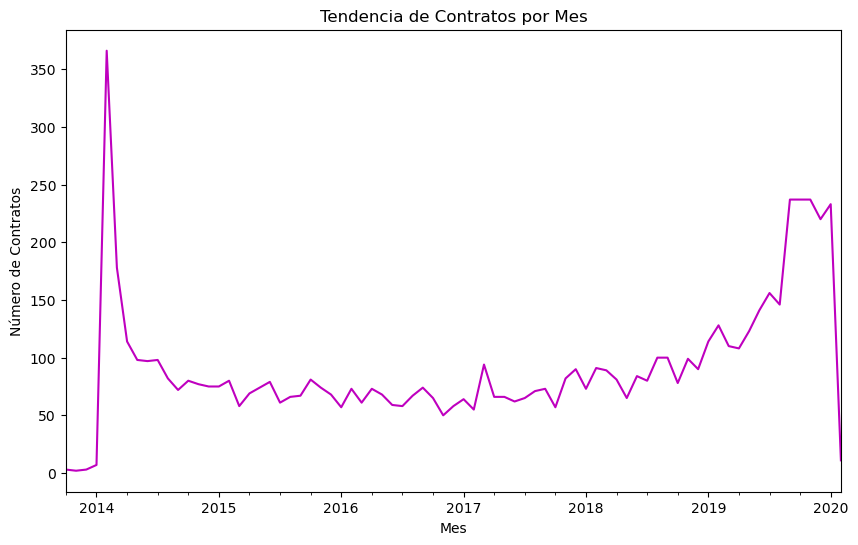

In [66]:
data_merged['begin_date'] = pd.to_datetime(data_merged['begin_date'])
monthly_data = data_merged.groupby(data_merged['begin_date'].dt.to_period('M')).size()

plt.figure(figsize=(10, 6))
monthly_data.plot(kind='line', color='m')
plt.title('Tendencia de Contratos por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Contratos')
plt.show()

A principios de 2014 hubo una gran cantidad de contrataciones, sin embargo, entre 2015 y 2018 disminuyó drásticamente, hasta que en 2019 este numero volvió a subir.  

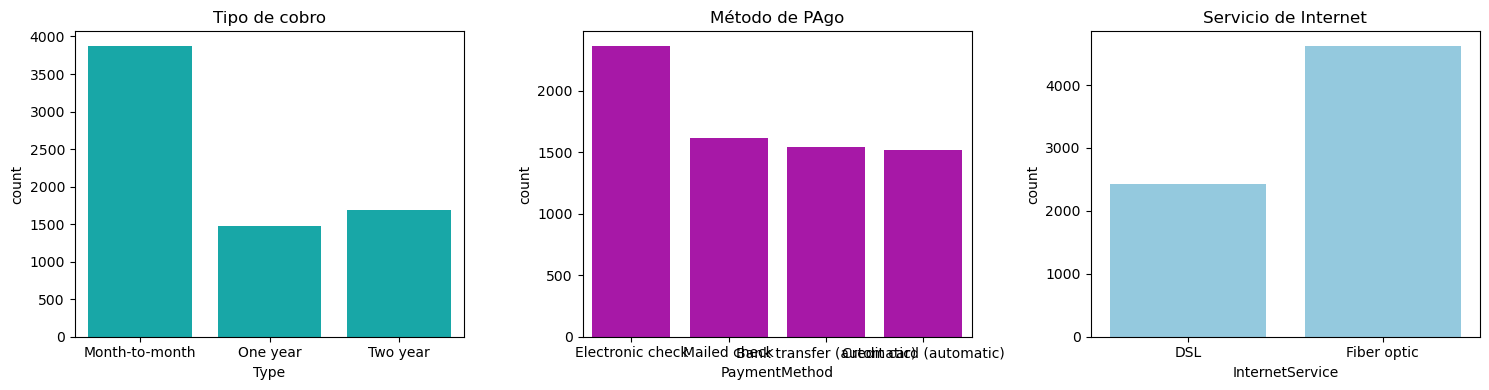

In [67]:
cols = ['Type', 'PaymentMethod', 'InternetService']

fig, axes = plt.subplots(1, len(cols), figsize=(15,4))

sns.countplot(x=data_graphics['Type'], data=data_graphics, ax=axes[0], color='c')
sns.countplot(x=data_graphics['PaymentMethod'], ax=axes[1],  color='m', )
sns.countplot(x=data_graphics['InternetService'], ax=axes[2],  color='skyblue')

axes[0].set_title('Tipo de cobro')
axes[1].set_title('Método de PAgo')
axes[2].set_title('Servicio de Internet')

fig.tight_layout()


plt.show()

Cantidad de usuarios por tipo de cobro, método de pago y tipo de Servicio de Internet

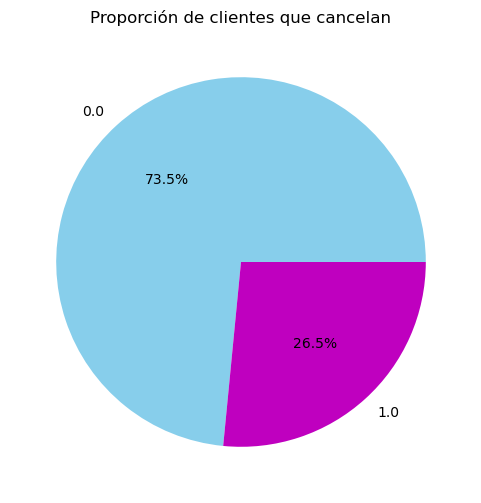

In [68]:
churn_counts = data_graphics['Churn'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=['skyblue', 'm'])
plt.title('Proporción de clientes que cancelan')
plt.show()

Grafica de pay de los usuarios que han cancelado, 1.0 = Sí han cancelado, 0.0 = no han cancelado.
El 26.5% ha cancelado su contrado con la empresa.

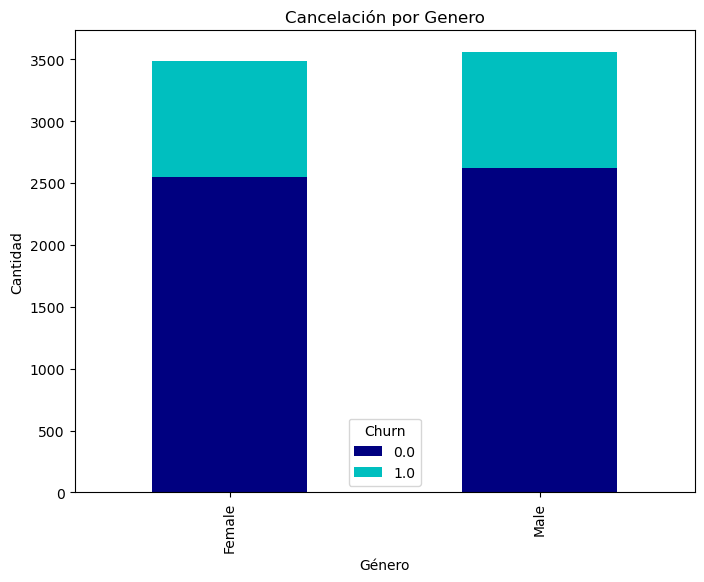

In [69]:
churn_by_service = data_graphics.groupby(['gender', 'Churn']).size().unstack()
churn_by_service.plot(kind='bar', stacked=True, figsize=(8, 6), color=['navy', 'c'])
plt.title('Cancelación por Genero')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.legend(title='Churn')
plt.show()

No se observan diferencias en el numero de cancelaciones de acuerdo al género del cliente

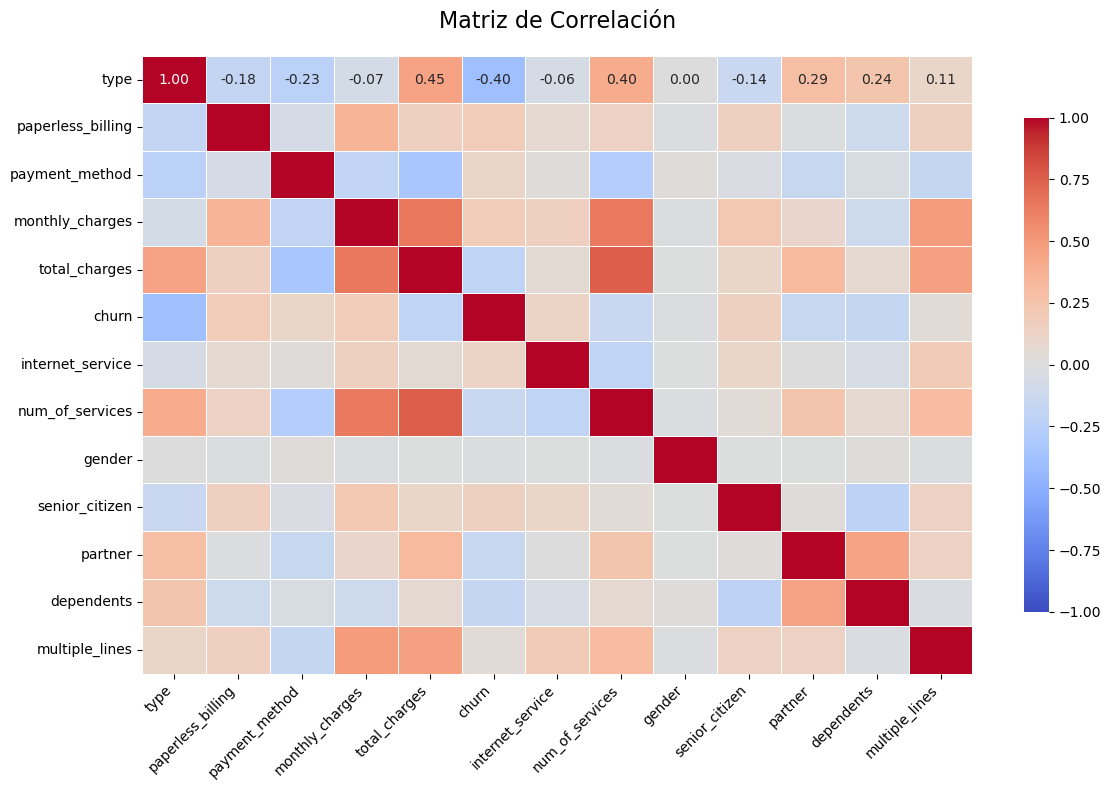

In [70]:
#Matriz de correlacion que permite visualizar la relación entre columnas 
data_to_correlate = data_transformed
corr = data_to_correlate.corr()
plt.figure(figsize=(12, 8))

sns.heatmap(
    corr, 
    annot=True, 
    cmap='coolwarm',  
    fmt=".2f",        
    linewidths=0.5,   
    vmin=-1, vmax=1,  
    cbar_kws={"shrink": 0.8}  
)

plt.title("Matriz de Correlación", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)               
plt.tight_layout()                   
plt.show()

Las columnas con correlacion cercana a 0, con respecto a la columna churn son: "gender" y "multiple_lines", por lo que serán eliminadas del modelo predictivo.

### Entrenamiento del Modelo

In [71]:
features = data_merged.drop(columns=['churn', 'customer_id', 'begin_date', 'end_date', 'gender', 'multiple_lines'])  
target = data_merged['churn']

features_train, features_others, target_train, target_others = train_test_split(features, target, test_size=0.4, random_state=123)
features_valid, features_test, target_valid, target_test = train_test_split(features_others, target_others, test_size=0.5, random_state=123)

numeric_features = features.select_dtypes(include=['float64', 'int64']).columns
categorical_features = features.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [72]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape) 
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(4225, 10)
(1409, 10)
(1409, 10)
(4225,)
(1409,)
(1409,)


#### Linear Regression

In [73]:
model_lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model_lr_pipeline.fit(features_train, target_train)

target_lr_proba = model_lr_pipeline.predict(features_test)

auc_roc_lr = roc_auc_score (target_test, target_lr_proba)

print("Linear Regression - Mean Squared Error:", mean_squared_error(target_test, target_lr_proba))
print("AUC-ROC:", auc_roc_lr)


Linear Regression - Mean Squared Error: 0.15107742791606502
AUC-ROC: 0.8114721508921743


#### Random Forest Classifier

In [74]:
features_encoded = data_transformed.drop(columns=['churn', 'gender', 'multiple_lines'])  
target_encoded = data_transformed['churn']

features_train_encoded, features_others_encoded, target_train_encoded, target_others_encoded = train_test_split(features_encoded, target_encoded, test_size=0.4, random_state=123)
features_valid_encoded, features_test_encoded, target_valid_encoded, target_test_encoded = train_test_split(features_others_encoded, target_others_encoded, test_size=0.5, random_state=123)


#model_rf = RandomForestClassifier()
#param_grid_rf = {
#    'n_estimators': [100, 200, 300, 400],  
#    'max_depth': [None, 5, 10, 20],      
#    'min_samples_split': [2, 5, 10],      
#    'min_samples_leaf': [1, 2, 4, 6]        
#}

#grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, verbose=1)

#grid_search_rf.fit(features_train_encoded, target_train_encoded)

#print(f"Mejores parámetros para el Random Forest:", grid_search_rf.best_params_)
#best_rf_model = grid_search_rf.best_estimator_
#target_rf_predict = best_rf_model.predict(features_test_encoded)
#auc_roc_rf_encoded = roc_auc_score (target_test, target_rf_predict)
#print("AUC-ROC:", auc_roc_rf_encoded)                        

model_rfc = RandomForestClassifier(n_estimators=400, max_depth=10, min_samples_leaf= 2, min_samples_split= 5)
model_rfc.fit(features_train_encoded, target_train_encoded)
target_rf_proba = model_rfc.predict(features_test_encoded)
auc_roc_rf = roc_auc_score (target_test, target_rf_proba)
print("AUC-ROC:", auc_roc_rf)
print(classification_report(target_test_encoded, target_rf_proba))


AUC-ROC: 0.7056698524607601
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1023
           1       0.67      0.51      0.58       386

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [75]:
data_merged.sample()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,internet_service,num_of_services,gender,senior_citizen,partner,dependents,multiple_lines
2398,7389-KBFIT,2019-12-01,2019-11-01 00:00:00,0.0,1.0,3.0,30.25,63.75,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


#### Modelo XGBClassifier

In [78]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=123))
])

#param_grid = {
#    'classifier__n_estimators': [100, 200, 300],  # Número de árboles
#    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasa de aprendizaje
#    'classifier__max_depth': [3, 4, 5, 6],  # Profundidad de los árboles
#    'classifier__min_child_weight': [1, 3, 5],  # Mínimo peso por nodo hijo
#    'classifier__subsample': [0.8, 0.9, 1.0],  # Proporción de muestras por árbol
#    'classifier__colsample_bytree': [0.8, 0.9, 1.0],  # Proporción de características por árbol
#    'classifier__gamma': [0, 0.1, 0.3],  # Regularización para la complejidad del árbol
#}
#
#grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, 
#                           cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
#
#
#grid_search.fit(features_train, target_train)
#
#
#print("Mejores parámetros encontrados:", grid_search.best_params_)
#
#
#best_xgb_model = grid_search.best_estimator_
#
# Realizar predicciones
#xgb_predictions = best_xgb_model.predict(features_test)
#
#
#auc_roc_xgb = roc_auc_score(target_test, xgb_predictions)
#
#
#print("XGBClassifier - Clasification Report:")
#print(classification_report(target_test, xgb_predictions))
#print("AUC-ROC:", auc_roc_xgb)

model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(features_train, target_train)
target_xgb_proba = model_xgb.predict(features_test)
auc_roc_xgb = roc_auc_score (target_test, target_xgb_proba)
print(classification_report(target_test, target_xgb_proba))
print("AUC-ROC:", auc_roc_xgb)


              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85      1023
         1.0       0.61      0.50      0.55       386

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.76      0.78      0.77      1409

AUC-ROC: 0.6885873611596494


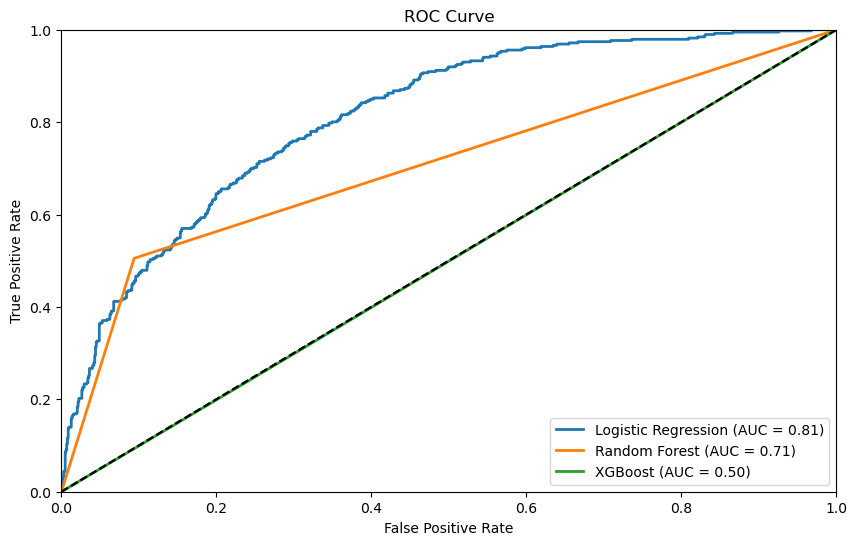

In [77]:
#Graficar las AUC-ROC de los tres modelos para comparar
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

fpr_lr, tpr_lr, thresholds_lr = roc_curve(target_test, target_lr_proba)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(target_test, target_rf_proba)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(target_test, target_xgb_proba)

plt.figure(figsize=(10, 6))
plot_roc_curve(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_roc_lr:.2f})')
plot_roc_curve(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_roc_rf:.2f})')
plot_roc_curve(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_roc_xgb:.2f})')
plt.legend(loc="lower right")
plt.show()

En este caso el modelo que mejor se ajustó de acuerdo con el valor AUC-ROC fue el de Regressión Logística con un valor de 0.81, despues el modelo de Random Forest con un valor de 0.7 y el modelo con menor ajuste fue el XGBoost con un AUC-ROC de 0.68.

### Predicciones

In [94]:
target_lr_df = model_lr_pipeline.predict(features_test)

target_rf_df = model_rfc.predict(features_test_encoded)

target_xgb_df = model_xgb.predict(features_test)

In [95]:
results = pd.DataFrame({
    'Actual': target_test.reset_index(drop=True),
    'Logistic Regression': target_lr_proba,
    'Random Forest': target_rf_proba,
    'XGBoost': target_xgb_proba
})

In [96]:
print(results.head())

   Actual  Logistic Regression  Random Forest  XGBoost
0     1.0             0.336738              0        0
1     1.0             0.554625              1        1
2     0.0             0.350631              0        0
3     0.0             0.281809              0        0
4     0.0             0.562491              0        1


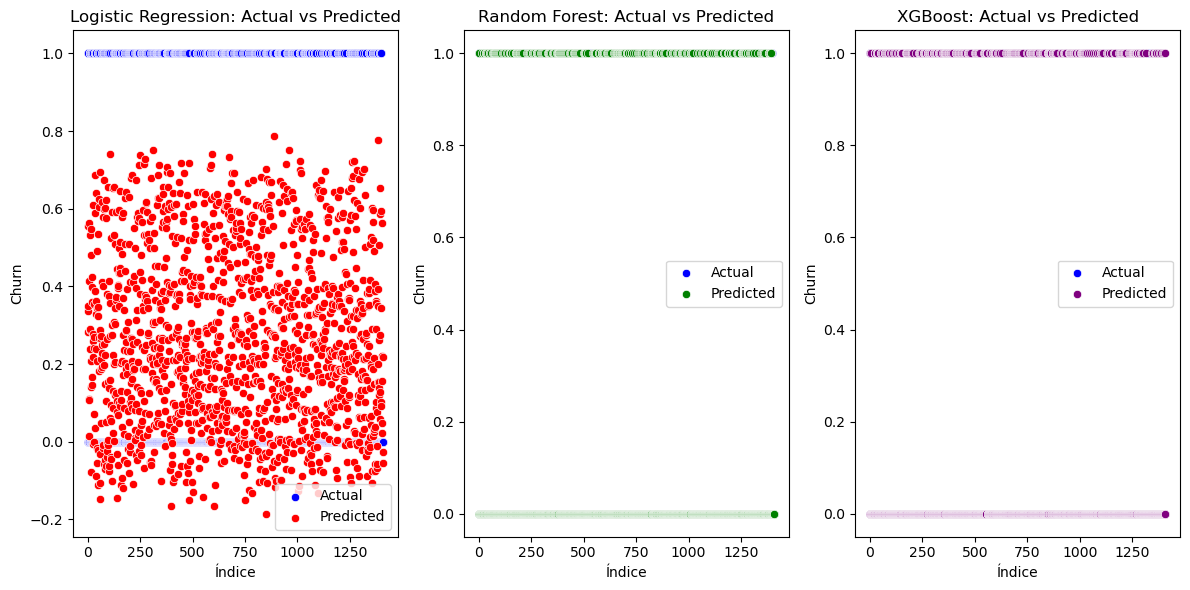

In [97]:
plt.figure(figsize=(12, 6))

# Gráfico para Regresión Logística
plt.subplot(1, 3, 1)
sns.scatterplot(x=results.index, y='Actual', data=results, color='blue', label='Actual')
sns.scatterplot(x=results.index, y='Logistic Regression', data=results, color='red', label='Predicted')
plt.title('Logistic Regression: Actual vs Predicted')
plt.xlabel('Índice')
plt.ylabel('Churn')
plt.legend()

# Gráfico para Random Forest
plt.subplot(1, 3, 2)
sns.scatterplot(x=results.index, y='Actual', data=results, color='blue', label='Actual')
sns.scatterplot(x=results.index, y='Random Forest', data=results, color='green', label='Predicted')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Índice')
plt.ylabel('Churn')
plt.legend()

# Gráfico para XGBoost
plt.subplot(1, 3, 3)
sns.scatterplot(x=results.index, y='Actual', data=results, color='blue', label='Actual')
sns.scatterplot(x=results.index, y='XGBoost', data=results, color='purple', label='Predicted')
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Índice')
plt.ylabel('Churn')
plt.legend()

plt.tight_layout()
plt.show()


### Conclusiones

La información para resolver este problema se encuentra en cuatro dataframes separados, por lo que fue necesario revisar individualmente la calidad y cantidad de la información, así como datos ausentes, datos duplicados y su formato. 

Asímismo fue necesario unir los dataframes con la columna que tuvieran en común, verificar la columna objetivo y las columnas que podríamos llamar como "ruido" que podrían impedir que funcionaran adecuadamente los modelos para eliminarlas.

Un reto importante fue rellenar los datos ausentes pues faltaban datos tanto en columnas categóticas como numéricas lo cual complicaba su manejo, sin embargo, existen herramientas muy útiles como el vecino más cercano, o rellenar con la media, mediana, o moda que dependiendo puede ser muy acertado usar.

La estandarización, escalado o codificado de datos fue muy importante para poder procesarlos, por ello, convertir los datos categóricos en numéricos para su análisis fue fundamental.

También fue necesario visualizar de qué forma se comportan los datos, por ello elegí columnas que describen a lo largo de tiempo el comportamiento de los usuarios, la proporción de usuarios que desertan y si existía alguna diferencia entre usuarios masculinos o femeninos. 

Otro punto funamental es determinar el grado de correlacion entre las caracteristicas y el objetivo, eso fue resuelto con un mapa de correlacion con gradiente de temperatura para eliminar las caracteristicas que no impactan en el objetivo.

Con lo anterior resuelto, fue posible entrenar los modelos, uno simple (regresion logistica), uno complejo(ramdom forest classifier) y uno simple pero eficaz (XGBM Classifier) para poder abordar el problema de clasificación.

Finalmente, el modelo que mejor se ajustó a las predicciones reales fue el modelo de Regresion Logistica tomando en cuenta métricas como accuracy y AUC-ROC que fueron mayores en la regresión, no tan lejos del bosque aleatr